# 0.Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- **top category id**
- **bottom category id**

The goal is to **maximize F1** for each of the classes on each attribute to predict (top category, bottom category). Your approaches and models will be benchmarked against a hidden test dataset.

**Bonus points** will be given for submissions that:

- **visualize some learned representations or embeddings** and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model

In [ ]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
import seaborn as sns
# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)


In [ ]:
# set random seed
np.random.seed(seed=42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = f"/content/drive/My Drive/DCU/Machine Learning/data/data_2025/2025/"

In [ ]:
print(os.path.join(PATH, 'train'))

/content/drive/My Drive/DCU/Machine Learning/data/data_2025/2025/train


In [ ]:
import os
parquet_filenames_train = os.listdir(os.path.join(PATH, 'train'))

In [ ]:
parquet_filenames_train[:3]

['part-00285-of-00362.parquet.parquet',
 'part-00206-of-00362.parquet.parquet',
 'part-00320-of-00362.parquet.parquet']

In [ ]:
f"Number of files in train: {len(parquet_filenames_train):,}"

'Number of files in train: 362'

In [ ]:
parquet_filenames_test = os.listdir(os.path.join(PATH, 'test'))

In [ ]:
parquet_filenames_test[:3]

['part-00109-of-00362.parquet.parquet',
 'part-00092-of-00362.parquet.parquet',
 'part-00123-of-00362.parquet.parquet']

In [ ]:
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

# 1.EDA

## 1.1 Training Dataset

In [ ]:
def read_data(folder, filenames):
    """ Read parquet data from mutiple files """

    dataframes = [
        pd.read_parquet(f"{PATH}/{folder}/{filename}")
        for filename in filenames
    ]

    return pd.concat(dataframes)

In [ ]:
df_train = read_data("train", parquet_filenames_train)

In [ ]:
df_train.shape

(229624, 23)

In [ ]:
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text']

In [ ]:
df_train.iloc[0]

,0
product_id,1500855633
title,Driftwood Solar Lamp Handcrafted Off Grid Sola...
description,Free shipping in Canada and the USA. This one...
tags,"Driftwood Lamp,driftwood solar,nautical,cottag..."
type,physical
room,patio & outdoor
craft_type,
recipient,
material,wood
occasion,


In [ ]:
df_train.iloc[0][3]

<ipython-input-17-680f671c668e>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train.iloc[0][3]


'Driftwood Lamp,driftwood solar,nautical,cottage decor,unique,one of a kind,handcrafted,off grid,garden decor,farmhouse decor,house boat decor,solar,garden store'

In [ ]:
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [ ]:
df_train['room'].unique()

array(['patio & outdoor', '', 'living room', 'entryway', 'game room',
       'craft', 'bedroom', 'office', 'kitchen & dining', 'nursery',
       'kids', 'dorm', 'bathroom', 'laundry', 'bar', 'porch', 'garage',
       'man cave', 'yard'], dtype=object)

In [ ]:
df_train['craft_type'].unique()

array(['', 'party & gifting', "kids' crafts", 'sculpture',
       'printing & printmaking', 'card making & stationery',
       'scrapbooking', 'bookbinding', 'ceramics & pottery', 'collage',
       'woodworking & carpentry', 'beading', 'jewelry making',
       'paper stamping', 'drawing & drafting', 'hat making & hair crafts',
       'floral arranging', 'crochet', 'knitting', 'watchmaking',
       'gardening', 'nail art', 'metalworking', 'sewing', 'quilting',
       'shoemaking', 'leatherworking', 'upholstery', 'photography',
       'needlepoint', 'embroidery', 'crewel', 'cross stitch',
       'electronics & circuitry', 'doll making', 'model making',
       'tatting & lacemaking', 'robotics', 'dollhouses & miniatures',
       'home improvement', 'painting', 'framing', 'coloring',
       '3d printing', 'calligraphy', 'rug making', 'dairy & kombucha',
       'neon art', 'dyeing & batik', 'carving & whittling', 'tattooing',
       'baking', 'stained glass', 'lampworking & shaping', 'candy

In [ ]:
len(df_train['top_category_id'].unique())

15

In [ ]:
len(df_train['top_category_text'].unique())

15

In [ ]:
len(df_train['bottom_category_id'].unique())

2609

In [ ]:
len(df_train['bottom_category_text'].unique())

2609

In [ ]:
# Checking what are the specific classes in top_category
pd.value_counts(df_train['top_category_id'], sort=True, ascending=False)

<ipython-input-25-4bfb92632ab6>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['top_category_id'], sort=True, ascending=False)


,count
top_category_id,
8,54600
6,33393
5,30143
13,13835
0,12416
10,12207
3,11327
14,10143
12,8892


In [ ]:
category_counts = pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

<ipython-input-26-fe4c1382cde2>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  category_counts = pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)


### 1.1.1 Top label distribution

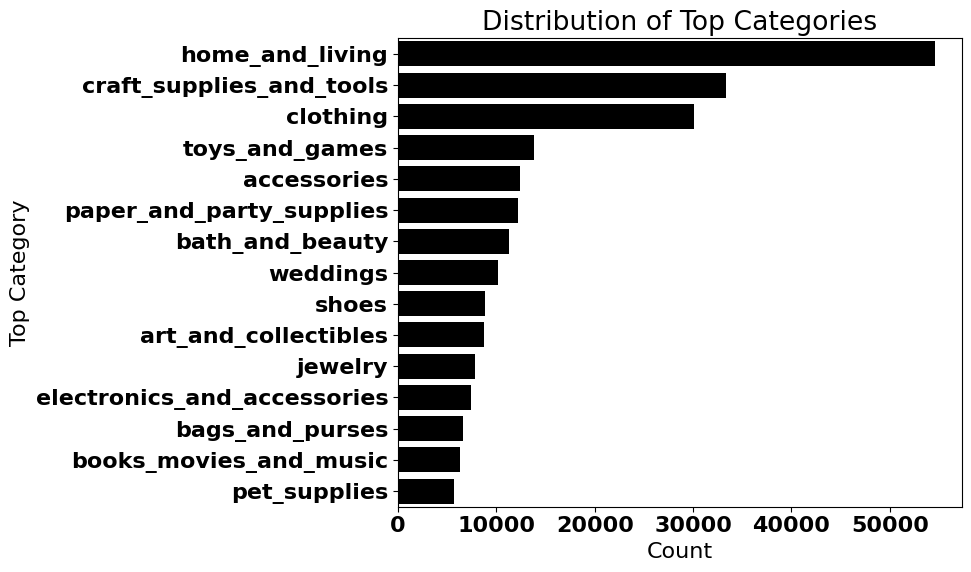

In [ ]:
# Visualizing top_category classes in training dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, color='black')

plt.xlabel("Count")
plt.ylabel("Top Category")
plt.title("Distribution of Top Categories")
plt.tight_layout()
plt.show()

### 1.1.2 Bottom label distribution

In [ ]:
#Checking what are the specific classes in bottom_category
pd.value_counts(df_train['bottom_category_text'], sort=True, ascending=False)

<ipython-input-28-50e2ff6a26eb>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_train['bottom_category_text'], sort=True, ascending=False)


,count
bottom_category_text,
art_and_collectibles.drawing_and_illustration.architectural_drawings,98
craft_supplies_and_tools.closures_and_fasteners.buttons,98
accessories.scarves_and_wraps.scarves,98
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands,98
toys_and_games.sports_and_outdoor_games.martial_arts_and_boxing.boxing_gloves,98
...,...
home_and_living.furniture.entryway_furniture.standing_coat_racks,44
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers,44
home_and_living.lighting.light_accessories,43


### 1.1.3 Checking minimum and maximum layers

In [ ]:
# Count the number of '.' in each entry
dot_counts = df_train['bottom_category_text'].str.count('\.')

# Get min and max
min_dots = dot_counts.min()
max_dots = dot_counts.max()

print(f"Minimum number of '.' : {min_dots}")
print(f"Maximum number of '.' : {max_dots}")

Minimum number of '.' : 0
Maximum number of '.' : 6


### 1.1.4 Title length distribution

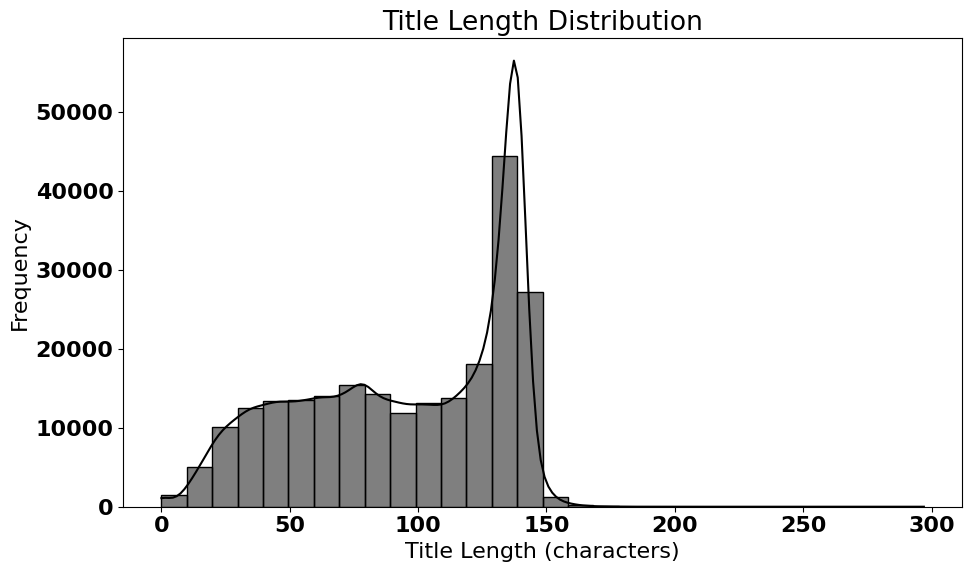

In [ ]:
# Compute title lengths
title_lengths = df_train['title'].str.len()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(title_lengths, bins=30, kde=True, color='black')

plt.title("Title Length Distribution")
plt.xlabel("Title Length (characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 1.1.5 Summarize


*   Raw training data size: (229624, 23)
*   Top layer have 15 classes, with highly imblanced distribution
*   Bottom layer have 2609 classes, class explosion problem
*   No mid layers directly given in terms of
either category id or category text
*   The bottom_category_text column contains between 0 and 6 occurrences of the '.' character, which suggests a hierarchical structure and indicates that the field can be split into multiple layers during feature engineering
*   The model can be trained using category_text text, which offer more descriptive information than category_id. After prediction, the associated category_id can be derived via their mapping.


## 1.2 Test dataset

The test dataset will be used to predict using the model/s you have trained




In [ ]:
df_test = read_data("test", parquet_filenames_test)

In [ ]:
df_test.shape

(25514, 15)

In [ ]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern']

In [ ]:
df_test.iloc[0]

,0
product_id,1397234990
title,Antler Skull Deer Skull Hand Painted Beads Dec...
description,Hand painted deer antlers.\nThe skull is natur...
tags,
type,physical
room,
craft_type,
recipient,
material,
occasion,


In [ ]:
df_test.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern
0,1397234990,Antler Skull Deer Skull Hand Painted Beads Dec...,Hand painted deer antlers.\nThe skull is natur...,,physical,,,,,,,,,,
1,1167322940,Hemifusus Conchilidium - Collectible Shell Spe...,Measures 2.625 x 1.625 x 1.25 inches.\n\nSeash...,"small conch,hemifusus,orange,orange shell,spir...",physical,,,,,,,,,,
2,1346575470,Excavation set with real bones / hammer chisel...,Discovery fun for young and old!\nThere are RE...,,physical,,,,,,,,,,
3,1607587430,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,"For sale is this glass filled with moss, pine ...",,physical,,,,,,,,,,
4,1633456300,Coyote Tooth and Freshwater Pearl Ornament | S...,Coyote Tooth and Freshwater Pearl Ornament 🌸\n...,"ostara,oddities,pagan art,goblincore,forest wi...",physical,,,,,birthday,,,,,


In [ ]:
df_train['bottom_category_id'].unique()

array([1117, 1582, 1143, ...,  989,  284,  977])

### 1.2.1 Title length distribution

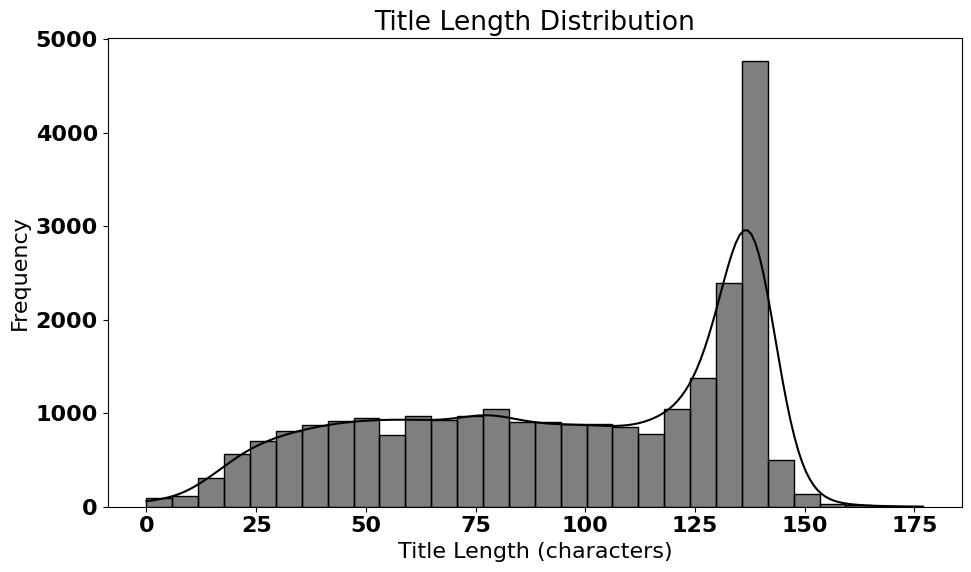

In [ ]:
# Compute title lengths
title_lengths = df_test['title'].str.len()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(title_lengths, bins=30, kde=True, color='black')

plt.title("Title Length Distribution")
plt.xlabel("Title Length (characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 1.2.2 Summarize



*   Test dataset size: (25514, 15)
*   Objective: predict top_category_id and bottom_category_id
*   Given descriptive columns: 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern'  



# 2.Feature Engineering

## 2-1 Layers splitting

In [ ]:
df1 = df_train.copy()

In [ ]:
def create_hierarchical_features(df):
    # Initialize each layer_text column (from layer1 to layer7) with empty strings
    for i in range(1, 8):
        df[f'layer{i}_category_text'] = ''

    # Function to split bottom_category_text by '.'
    def split_categories(text):
        return text.split('.') if isinstance(text, str) else []

    # Apply the splitting function to the bottom_category_text column
    category_lists = df['bottom_category_text'].apply(split_categories)

    # Assign each layer value and generate cumulative hierarchical paths
    for i in range(1, 8):
        df[f'layer{i}_category_text'] = category_lists.apply(
            lambda cats: '.'.join(cats[:i]) if i <= len(cats) else ''
        )

    return df

In [ ]:
# Function test
small_test = {
    'id': [1, 2, 3, 4, 5],
    'top_category_text': ['electronics', 'clothing', 'books', 'home', 'beauty'],
    'bottom_category_text': [
        'electronics.phones.smartphones.android',
        'clothing.women.dresses',
        'books',
        'home.kitchen.appliances.coffee_makers',
        'beauty.skincare.moisturizers'
    ]
}

In [ ]:
function_test_df = pd.DataFrame(small_test)

In [ ]:
function_test_df.head()

,id,top_category_text,bottom_category_text
0,1,electronics,electronics.phones.smartphones.android
1,2,clothing,clothing.women.dresses
2,3,books,books
3,4,home,home.kitchen.appliances.coffee_makers
4,5,beauty,beauty.skincare.moisturizers


In [ ]:
df_test_example = create_hierarchical_features(function_test_df)

In [ ]:
df_test_example

,id,top_category_text,bottom_category_text,layer1_category_text,layer2_category_text,layer3_category_text,layer4_category_text,layer5_category_text,layer6_category_text,layer7_category_text
0,1,electronics,electronics.phones.smartphones.android,electronics,electronics.phones,electronics.phones.smartphones,electronics.phones.smartphones.android,,,
1,2,clothing,clothing.women.dresses,clothing,clothing.women,clothing.women.dresses,,,,
2,3,books,books,books,,,,,,
3,4,home,home.kitchen.appliances.coffee_makers,home,home.kitchen,home.kitchen.appliances,home.kitchen.appliances.coffee_makers,,,
4,5,beauty,beauty.skincare.moisturizers,beauty,beauty.skincare,beauty.skincare.moisturizers,,,,


In [ ]:
df2 = create_hierarchical_features(df1)

In [ ]:
df2.iloc[0]

,0
product_id,1500855633
title,Driftwood Solar Lamp Handcrafted Off Grid Sola...
description,Free shipping in Canada and the USA. This one...
tags,"Driftwood Lamp,driftwood solar,nautical,cottag..."
type,physical
room,patio & outdoor
craft_type,
recipient,
material,wood
occasion,


In [ ]:
df_train.shape[0]

229624

In [ ]:
non_empty_count = (df2['layer5_category_text'] != '').sum()
print(non_empty_count)

36762


In [ ]:
layers = ['layer1_category_text', 'layer2_category_text', 'layer3_category_text', 'layer4_category_text', 'layer5_category_text', 'layer6_category_text', 'layer7_category_text', 'bottom_category_text']
layer_counts = []
for layer in layers:
    non_empty_counts = (df2[layer] != '').sum()
    layer_counts.append(non_empty_counts)

layer_counts

[np.int64(229624),
 np.int64(228279),
 np.int64(214987),
 np.int64(127766),
 np.int64(36762),
 np.int64(6269),
 np.int64(93),
 np.int64(229624)]

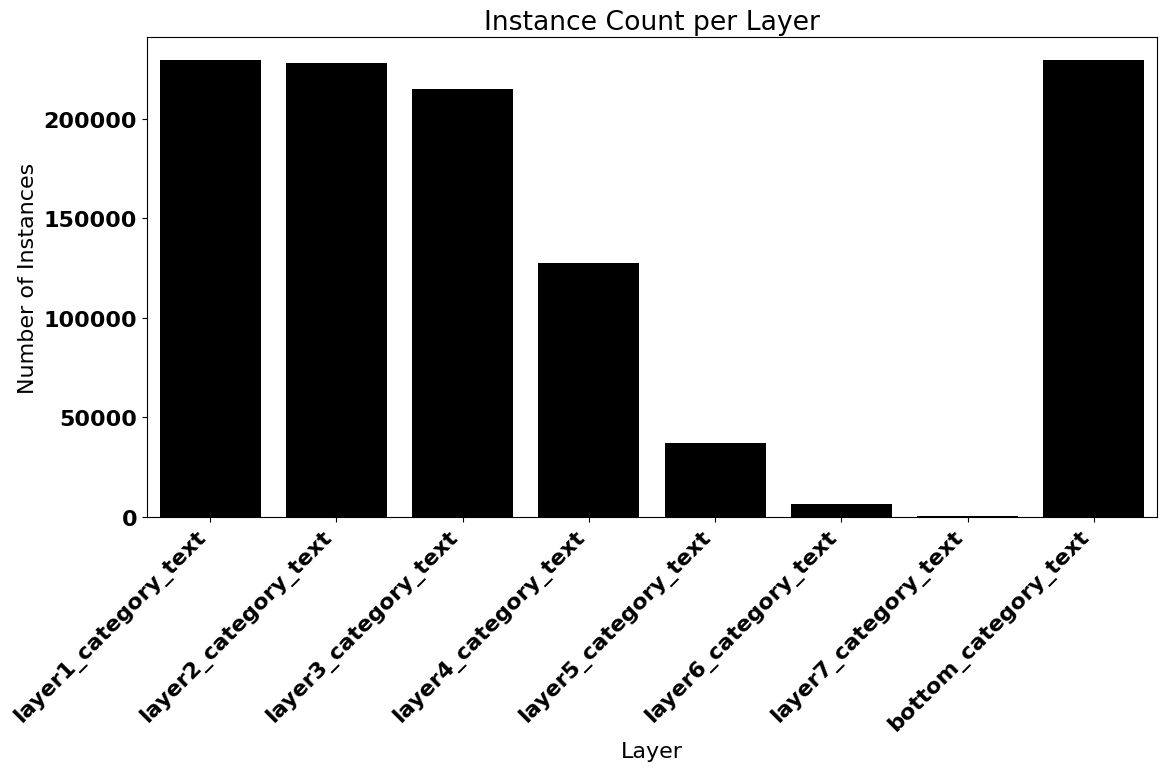

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=layers, y=layer_counts, color='black')

plt.title("Instance Count per Layer")
plt.xlabel("Layer")
plt.ylabel("Number of Instances")

# Rotate and align x-tick labels to the left
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



## 2-2 Text processing

In [ ]:
import re

# Text preprocessing function
def preprocess_text(text):
   if pd.isna(text):
       return ""
   # Remove HTML tags
   text = re.sub(r'&[a-zA-Z0-9]+;', ' ', text)
   # Remove URLs with www
   text = re.sub(r'www\.[^\s]+', ' ', text)
   # Replace special characters with spaces
   text = re.sub(r'[^\w\s]', ' ', text)
   # Replace multiple spaces with a single space
   text = re.sub(r'\s+', ' ', text)
   return text.lower().strip()

# Feature combination function with all features
def combine_all_features(row):
    features = []

    columns = ['title', 'description', 'tags','type', 'room', 'craft_type',
               'recipient', 'material', 'occasion', 'holiday',
               'art_subject', 'style', 'shape', 'pattern']

    for col in columns:
        if not pd.isna(row[col]) and row[col] != '':
            features.append(str(row[col]))

    return ' '.join(features)

In [ ]:
processed_train_df = df2.copy()

In [ ]:
processed_train_df['all_features'] = processed_train_df.apply(combine_all_features, axis=1)
processed_train_df['processed_text_all'] = processed_train_df['all_features'].apply(preprocess_text)

In [ ]:
processed_train_df.shape

(229624, 32)

In [ ]:
processed_train_df.iloc[0][-1]

<ipython-input-55-535c542328b9>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  processed_train_df.iloc[0][-1]


'driftwood solar lamp handcrafted off grid solar night light garden driftwood solar light gazebo light sleep camp light free shipping in canada and the usa this one of a kind solar driftwood lamp is ready for any setting such as a garden cottage sun room sleep camp off grid and any nautical decor it is 15 5 inches tall by 10 inches long absolutely beautiful piece of artwork if you have any questions please feel free to contact me anytime driftwood lamp driftwood solar nautical cottage decor unique one of a kind handcrafted off grid garden decor farmhouse decor house boat decor solar garden store physical patio outdoor wood'

67362


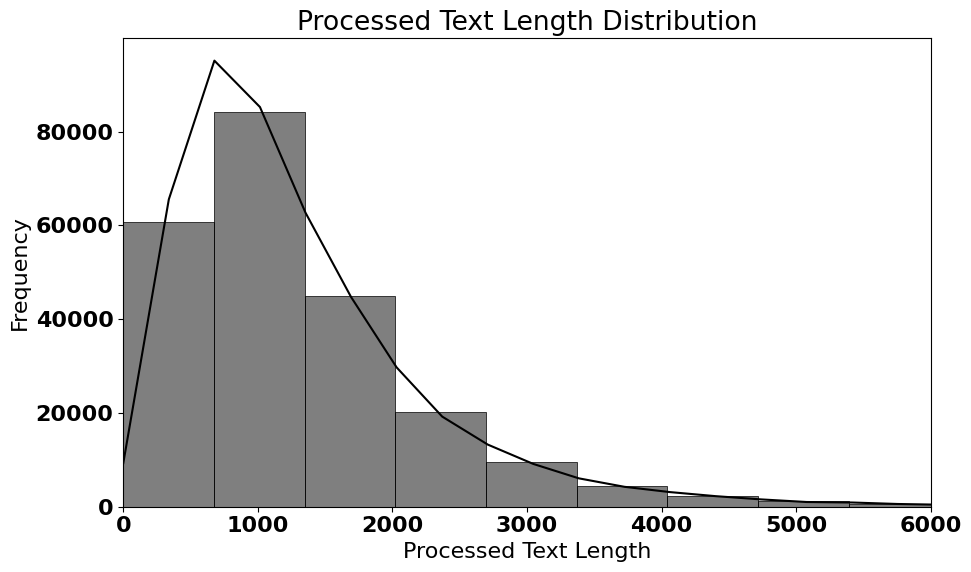

In [ ]:
# Compute title lengths
text_lengths = processed_train_df['processed_text_all'].str.len()
print(text_lengths.max())

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=100, kde=True, color='black')

plt.title("Processed Text Length Distribution")
plt.xlabel("Processed Text Length")
plt.ylabel("Frequency")
plt.xlim(0, 6000)
plt.tight_layout()
plt.show()

In [ ]:
pip install fasttext

# 3.Modeling
* Method: Fasttext Supervised Learning

## 3.1 Top Category


### 3.1.1 Data Splitting

In [ ]:
df4 = processed_train_df.copy()

In [ ]:
df4['top_category_target'] = '__label__' + df4['top_category_id'].astype(str)
df4['description_to_target'] = df4['top_category_target'] + " " + df4['processed_text_all']

In [ ]:
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(
    df4,
    test_size=0.2,
    stratify=df4['top_category_id'],
    random_state=42
)

In [ ]:
train_df.shape, val_df.shape

((183699, 34), (45925, 34))

In [ ]:
# saving data as file, it is a key step at fasttext supervised learning
train_df.to_csv("top.train", columns=['description_to_target'], index=False, header=False)
val_df.to_csv("top.val", columns=['description_to_target'], index=False, header=False)

### 3.1.2 Modeling

In [ ]:
pip install fasttext

In [ ]:
import fasttext

base_model = fasttext.train_supervised(
    input='top.train'
)

In [ ]:
base_model.test('top.val')

(45925, 0.8610560696788242, 0.8610560696788242)

In [ ]:
model1 = fasttext.train_supervised(
    input='top.train',
    lr = 1.5,
    dim = 70,
    epoch = 6,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'

)

In [ ]:
model1.test('top.val')

(45925, 0.899858464888405, 0.899858464888405)

### 3.1.3 Evaluating

In [ ]:
def evaluate_fasttext_by_category(model, test_file):
   """
   Calculate precision, recall, f1 score for each category in a FastText model.

   Args:
       model: Trained FastText model
       test_file: Path to test file in FastText format (__label__category text)

   Returns:
       DataFrame: Performance metrics by category
   """

   from collections import defaultdict

   # Counters to track TP, FP, FN for each category
   true_positives = defaultdict(int)
   false_positives = defaultdict(int)
   false_negatives = defaultdict(int)
   total_by_category = defaultdict(int)

   # Read test file
   with open(test_file, 'r', encoding='utf-8') as f:
       for line in f:
           line = line.strip()
           if not line:
               continue

           # Split label and text
           parts = line.split(' ', 1)
           if len(parts) < 2:
               continue

           true_label = parts[0].replace('__label__', '')
           text = parts[1]

           # Make prediction
           predictions = model.predict([text], k=1)
           predicted_label = predictions[0][0][0].replace('__label__', '')

           # Increment actual category count
           total_by_category[true_label] += 1

           # Update accuracy metrics
           if predicted_label == true_label:
               true_positives[true_label] += 1
           else:
               false_positives[predicted_label] += 1
               false_negatives[true_label] += 1

    # Calculate results
   categories = sorted(total_by_category.keys())
   results = []

   for category in categories:
       # Calculate precision, recall, F1
       tp = true_positives[category]
       fp = false_positives[category]
       fn = false_negatives[category]
       total = total_by_category[category]

       precision = tp / (tp + fp) if (tp + fp) > 0 else 0
       recall = tp / (tp + fn) if (tp + fn) > 0 else 0
       f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

       results.append({
           'category': category,
           'precision': precision,
           'recall': recall,
           'f1': f1,
           'support': total
       })
   # Convert to DataFrame
   df_results = pd.DataFrame(results)

   # Calculate weighted average
   weighted_sum_p = (df_results['precision'] * df_results['support']).sum()
   weighted_sum_r = (df_results['recall'] * df_results['support']).sum()
   weighted_sum_f1 = (df_results['f1'] * df_results['support']).sum()
   total_support = df_results['support'].sum()
   weighted_avg = {
       'category': 'weighted avg',
       'precision': weighted_sum_p / total_support if total_support > 0 else 0,
       'recall': weighted_sum_r / total_support if total_support > 0 else 0,
       'f1': weighted_sum_f1 / total_support if total_support > 0 else 0,
       'support': total_support
   }
   df_results = pd.concat([df_results, pd.DataFrame([weighted_avg])], ignore_index=True)

   return df_results

In [ ]:
evaluate_fasttext_by_category(base_model, 'top.train')

,category,precision,recall,f1,support
0,0,0.851637,0.840834,0.846201,9933
1,1,0.824979,0.696257,0.755172,6973
2,10,0.851411,0.856206,0.853802,9764
3,11,0.954202,0.906855,0.929926,4595
4,12,0.960073,0.966685,0.963368,7114
5,13,0.896842,0.885255,0.891011,11068
6,14,0.782227,0.625955,0.695420,8114
7,2,0.861262,0.864662,0.862958,5320
8,3,0.923322,0.895608,0.909254,9062
9,4,0.920197,0.893014,0.906402,5010


In [ ]:
evaluate_fasttext_by_category(base_model, 'top.val')

,category,precision,recall,f1,support
0,0,0.803601,0.790979,0.797240,2483
1,1,0.755650,0.613884,0.677430,1743
2,10,0.828170,0.821048,0.824594,2442
3,11,0.933707,0.870322,0.900901,1149
4,12,0.960818,0.951631,0.956202,1778
5,13,0.860377,0.823997,0.841794,2767
6,14,0.710938,0.583046,0.640672,2029
7,2,0.818598,0.807519,0.813020,1330
8,3,0.884791,0.857837,0.871105,2265
9,4,0.874074,0.848243,0.860965,1252


In [ ]:
evaluate_fasttext_by_category(model1, 'top.train')

,category,precision,recall,f1,support
0,0,0.988053,0.982483,0.985260,9933
1,1,0.996122,0.994694,0.995408,6973
2,10,0.978658,0.981565,0.980109,9764
3,11,0.994318,0.990207,0.992258,4595
4,12,0.994256,0.997610,0.995930,7114
5,13,0.992049,0.980755,0.986370,11068
6,14,0.981395,0.962164,0.971685,8114
7,2,0.979936,0.982331,0.981132,5320
8,3,0.990152,0.987420,0.988784,9062
9,4,0.996400,0.994411,0.995405,5010


In [ ]:
evaluate_fasttext_by_category(model1, 'top.val')

,category,precision,recall,f1,support
0,0,0.861179,0.846959,0.854010,2483
1,1,0.826649,0.697648,0.756689,1743
2,10,0.863506,0.865274,0.864389,2442
3,11,0.936266,0.907746,0.921785,1149
4,12,0.970737,0.970191,0.970464,1778
5,13,0.894796,0.863751,0.879000,2767
6,14,0.801667,0.711188,0.753722,2029
7,2,0.859806,0.866917,0.863347,1330
8,3,0.914056,0.901545,0.907757,2265
9,4,0.907830,0.888978,0.898305,1252


### 3.1.4 Visualizing Actual Data Point VS Predicted Data Point

> Since we set dim=70 in model1, the text is represented in a 70-dimensional vector space. To visualize this high-dimensional data, we can use PCA to reduce it to 2 or 3 dimensions.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# 1. Extract texts and labels from test file
def load_test_data(test_file, model):
   texts = []
   true_labels = []
   predicted_labels = []

   with open(test_file, 'r', encoding='utf-8') as f:
       for line in f:
           line = line.strip()
           if not line:
               continue

           parts = line.split(' ', 1)
           if len(parts) < 2:
               continue

           true_label = parts[0].replace('__label__', '')
           text = parts[1]

           texts.append(text)
           true_labels.append(true_label)

           # Make prediction
           predictions = model.predict([text], k=1)
           predicted_label = predictions[0][0][0].replace('__label__', '')
           predicted_labels.append(predicted_label)

   return texts, true_labels, predicted_labels

In [ ]:
test_file = 'top.val'
texts = load_test_data(test_file, model1)[0]
true_labels = load_test_data(test_file, model1)[1]
predicted_labels = load_test_data(test_file, model1)[2]

In [ ]:
len(texts)

45925

In [ ]:
# 2. Convert texts to vectors
def get_text_vectors(model, texts):
   vectors = []
   for text in texts:
       # Get sentence vector from FastText model
       vector = model.get_sentence_vector(text)
       vectors.append(vector)
   return np.array(vectors)

In [ ]:
vector = get_text_vectors(model1, texts)

In [ ]:
vector.shape

(45925, 70)

In [ ]:
# 3. Reduce dimensions using PCA
def reduce_dimensions(vectors, n_components=2):
   pca = PCA(n_components=n_components)
   reduced_vectors = pca.fit_transform(vectors)

   # Explained variance ratio for each principal component
   print(f"PCA1 explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")
   print(f"PCA2 explained variance ratio: {pca.explained_variance_ratio_[1]:.4f}")
   print(f"Total explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

   return reduced_vectors, pca

In [ ]:
vectors_2d = reduce_dimensions(vector)

PCA1 explained variance ratio: 0.2605
PCA2 explained variance ratio: 0.2011
Total explained variance ratio: 0.4616


In [ ]:
reduced_vectors = vectors_2d[0]
reduced_vectors.shape

(45925, 2)

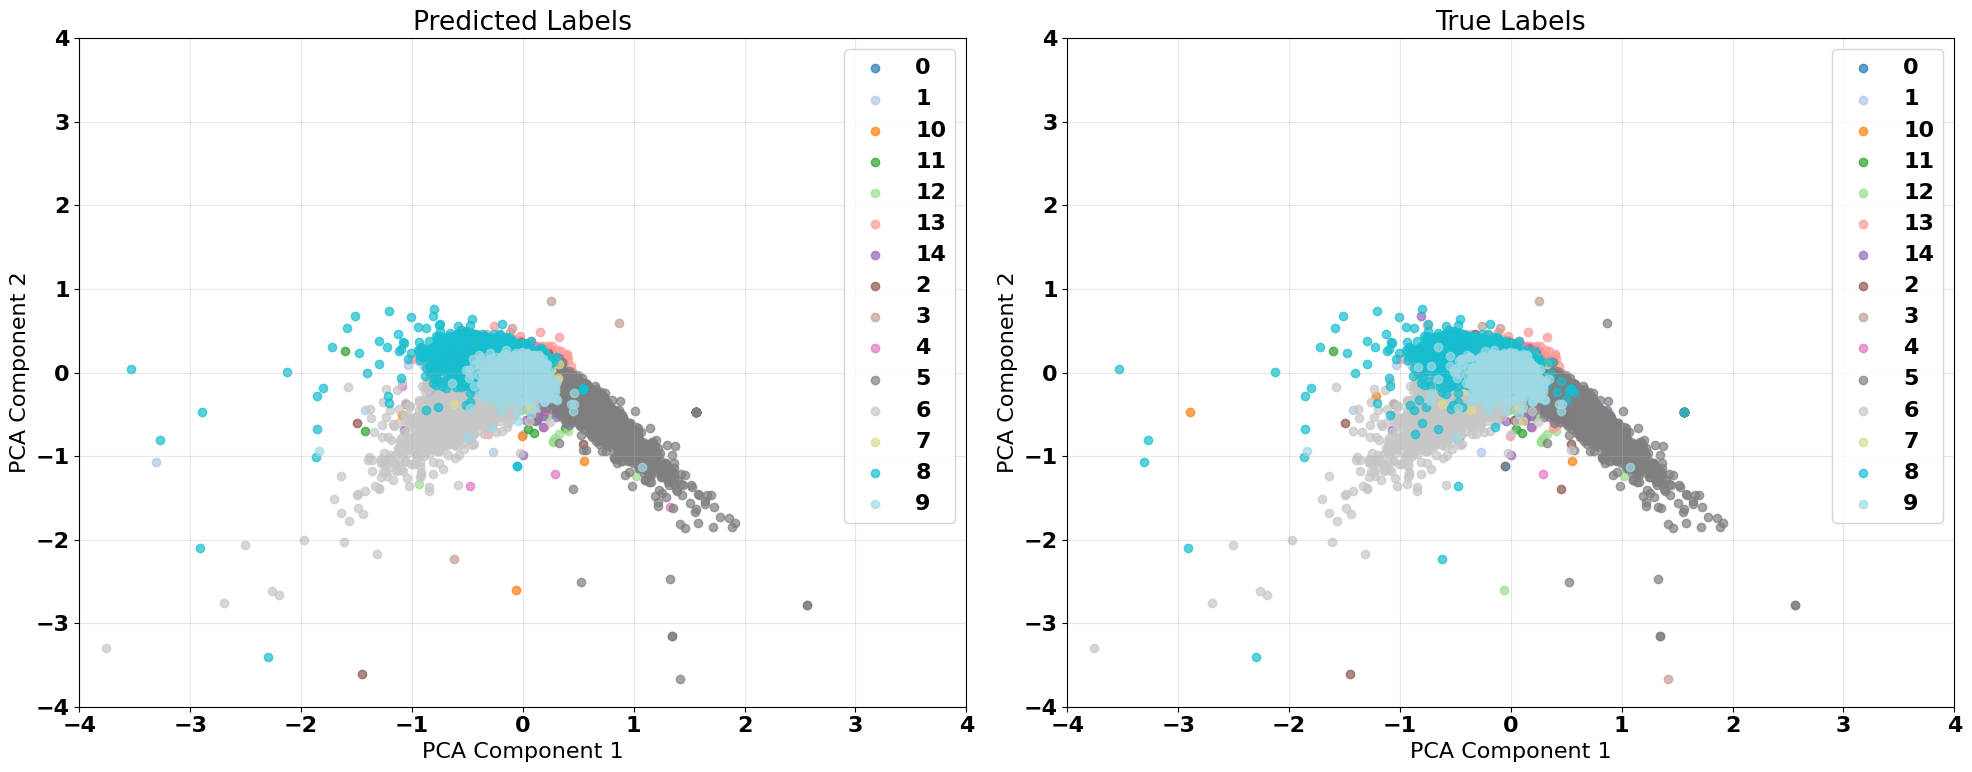

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First subplot - Predicted Labels
unique_labels_pred = sorted(set(predicted_labels))
colors_pred = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_pred)))

for i, label in enumerate(unique_labels_pred):
    indices = [j for j, l in enumerate(predicted_labels) if l == label]
    points = reduced_vectors[indices]
    ax1.scatter(points[:, 0], points[:, 1], color=colors_pred[i], label=label, alpha=0.7)

ax1.set_title("Predicted Labels")
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

# Second subplot - True Labels
unique_labels_true = sorted(set(true_labels))
colors_true = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_true)))

for i, label in enumerate(unique_labels_true):
    indices = [j for j, l in enumerate(true_labels) if l == label]
    points = reduced_vectors[indices]
    ax2.scatter(points[:, 0], points[:, 1], color=colors_true[i], label=label, alpha=0.7)

ax2.set_title("True Labels")
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/DCU/Machine Learning/labels_comparison.png', dpi=300)
plt.show()

### 3.1.5 Final model training
> Final model is trained on the combination of training and validation sets with optimal parameters

In [ ]:
df4.to_csv("all_data.retrain", columns=['description_to_target'], index=False, header=False)

In [ ]:
# Best parameters
final_model = fasttext.train_supervised(
    input='all_data.retrain',
    lr = 1.5,
    dim = 70,
    epoch = 6,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'
)

### 3.1.6 Final Predicting - Top category

In [ ]:
df_test.shape

(25514, 15)

In [ ]:
df_test['all_features'] = df_test.apply(combine_all_features, axis=1)
df_test['processed_text_all'] = df_test['all_features'].apply(preprocess_text)

In [164]:
df_test['pred_top_category_id'] = df_test['processed_text_all'].apply(
    lambda x: final_model.predict([x])[0][0][0].replace('__label__', '')
)

In [165]:
df_test.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern,all_features,processed_text_all,top_category_id,pred_top_category_id
0,1397234990,Antler Skull Deer Skull Hand Painted Beads Dec...,Hand painted deer antlers.\nThe skull is natur...,,physical,,,,,,,,,,,Antler Skull Deer Skull Hand Painted Beads Dec...,antler skull deer skull hand painted beads dec...,8,8
1,1167322940,Hemifusus Conchilidium - Collectible Shell Spe...,Measures 2.625 x 1.625 x 1.25 inches.\n\nSeash...,"small conch,hemifusus,orange,orange shell,spir...",physical,,,,,,,,,,,Hemifusus Conchilidium - Collectible Shell Spe...,hemifusus conchilidium collectible shell speci...,8,8
2,1346575470,Excavation set with real bones / hammer chisel...,Discovery fun for young and old!\nThere are RE...,,physical,,,,,,,,,,,Excavation set with real bones / hammer chisel...,excavation set with real bones hammer chisel b...,13,13
3,1607587430,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,"For sale is this glass filled with moss, pine ...",,physical,,,,,,,,,,,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,rabbit 39 s paw rabbit foot paw claw glass dec...,8,8
4,1633456300,Coyote Tooth and Freshwater Pearl Ornament | S...,Coyote Tooth and Freshwater Pearl Ornament 🌸\n...,"ostara,oddities,pagan art,goblincore,forest wi...",physical,,,,,birthday,,,,,,Coyote Tooth and Freshwater Pearl Ornament | S...,coyote tooth and freshwater pearl ornament spr...,8,8


In [ ]:
# Checking what are the specific classes in top_category
category_counts = pd.value_counts(df_test['top_category_id'], sort=True, ascending=False)

<ipython-input-91-89dd72e95f45>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  category_counts = pd.value_counts(df_test['top_category_id'], sort=True, ascending=False)


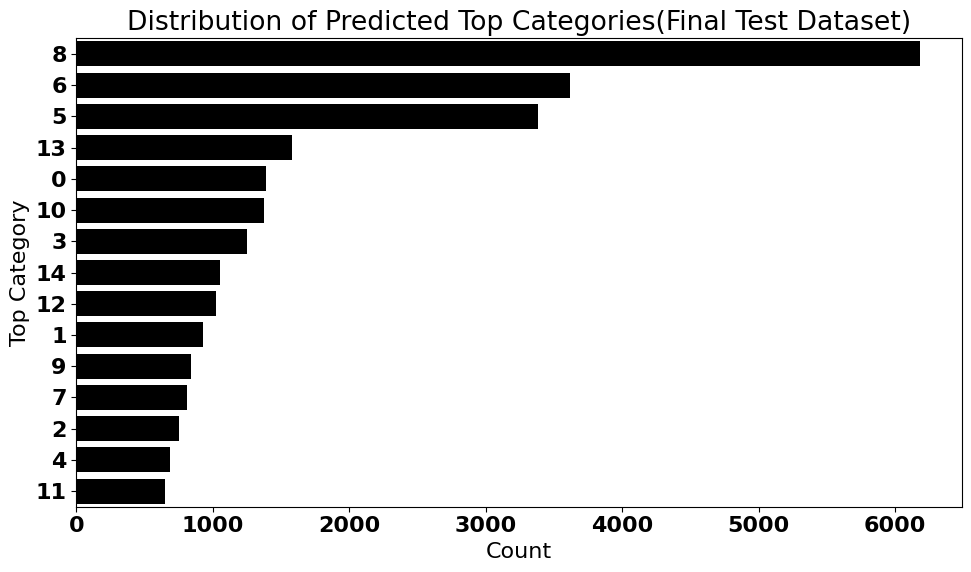

In [ ]:
# Visualizing top_category classes in training dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, color='black')

plt.xlabel("Count")
plt.ylabel("Top Category")
plt.title("Distribution of Predicted Top Categories(Final Test Dataset)")
plt.tight_layout()
plt.show()

## 3.2 Bottom Category



1.   Bottom layer have 2609 classes, class explosion problem
2.   No mid layers directly given in terms of either category id or category text
3.   The bottom_category_text column contains between 0 and 6 occurrences of the '.' character, which suggests a hierarchical structure
4.   The model can be trained using category_text text, which offer more descriptive information than category_id. After prediction, the associated category_id can be derived via their mapping.

In [ ]:
def create_layer_datasets(df):
    """
    Creates 7 DataFrames by extracting only the non-empty rows
    from each layer column (layer1_category_text to layer7_category_text).

    Parameters:
    df (pandas.DataFrame): Input DataFrame

    Returns:
    dict: A dictionary containing a DataFrame for each layer
    """
    # Initialize dictionary to store results
    layer_datasets = {}

    # Process each layer
    for i in range(1, 8):
        # Layer column name
        layer_col = f'layer{i}_category_text'

        # Check if the layer column exists in the DataFrame
        if layer_col not in df.columns:
            print(f"Warning: Column {layer_col} does not exist in the DataFrame.")
            layer_datasets[f'df_layer{i}'] = pd.DataFrame()  # Empty DataFrame
            continue

        # Select rows where the column is not empty
        layer_df = df[df[layer_col] != '']

        # Save the result
        layer_datasets[f'df_layer{i}'] = layer_df

        # Print information
        print(f"df_layer{i}: {layer_df.shape}")

    return layer_datasets


In [ ]:
df5 = processed_train_df.copy()
layer_datasets = create_layer_datasets(df5)

df_layer1: (229624, 32)
df_layer2: (228279, 32)
df_layer3: (214987, 32)
df_layer4: (127766, 32)
df_layer5: (36762, 32)
df_layer6: (6269, 32)
df_layer7: (93, 32)


In [ ]:
df_layer1 = layer_datasets['df_layer1']
df_layer2 = layer_datasets['df_layer2']
df_layer3 = layer_datasets['df_layer3']
df_layer4 = layer_datasets['df_layer4']
df_layer5 = layer_datasets['df_layer5']
df_layer6 = layer_datasets['df_layer6']
df_layer7 = layer_datasets['df_layer7']

In [ ]:
df_bottom = df5

In [ ]:
print(df_layer1.shape)
print(df_layer2.shape)
print(df_layer3.shape)
print(df_layer4.shape)
print(df_layer5.shape)
print(df_layer6.shape)
print(df_layer7.shape)
print(df_bottom.shape)

(229624, 32)
(228279, 32)
(214987, 32)
(127766, 32)
(36762, 32)
(6269, 32)
(93, 32)
(229624, 32)


In [ ]:
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split


def generate_lev_df(df, layer):
  df[f'{layer}_category'] = '__label__' + df[f'{layer}_category_text'].astype(str)
  df[f'{layer}_category_with_text'] = df[f'{layer}_category'] + " " + df['processed_text_all']

  return df

def save_input_file(df, layer):
  # Split training/validation data
  train, val = train_test_split(
    df,
    test_size=0.2,
    stratify=df[f'{layer}_category_text'],   #equal distribution of category in each layer
    random_state=42
)
  print(f"Training data size: {len(train)}")
  print(f"Validation data size: {len(val)}")

  train.to_csv(f"{basic_path}/{layer}.train", columns=[f'{layer}_category_with_text'], index=False, header=False)
  val.to_csv(f"{basic_path}/{layer}.val", columns=[f'{layer}_category_with_text'], index=False, header=False)

In [ ]:
df_layer1_input = generate_lev_df(df_layer1, layer='layer1')
df_layer2_input = generate_lev_df(df_layer2, layer='layer2')
df_layer3_input = generate_lev_df(df_layer3, layer='layer3')
df_layer4_input = generate_lev_df(df_layer4, layer='layer4')
df_layer5_input = generate_lev_df(df_layer5, layer='layer5')
df_layer6_input = generate_lev_df(df_layer6, layer='layer6')
df_layer7_input = generate_lev_df(df_layer7, layer='layer7')
df_bottom_input = generate_lev_df(df_bottom, layer='bottom')

<ipython-input-98-a73accd69dc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{layer}_category'] = '__label__' + df[f'{layer}_category_text'].astype(str)
<ipython-input-98-a73accd69dc4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{layer}_category_with_text'] = df[f'{layer}_category'] + " " + df['processed_text_all']
<ipython-input-98-a73accd69dc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [ ]:
df_bottom_input.shape

(229624, 34)

In [ ]:
basic_path = '/content/drive/My Drive/DCU/Machine Learning/level/'
save_input_file(df_layer1_input, layer='layer1')
save_input_file(df_layer2_input, layer='layer2')
save_input_file(df_layer3_input, layer='layer3')
save_input_file(df_layer4_input, layer='layer4')
save_input_file(df_layer5_input, layer='layer5')
save_input_file(df_layer6_input, layer='layer6')
save_input_file(df_layer7_input, layer='layer7')
save_input_file(df_bottom_input, layer='bottom')

Training data size: 183699
Validation data size: 45925
Training data size: 182623
Validation data size: 45656
Training data size: 171989
Validation data size: 42998
Training data size: 102212
Validation data size: 25554
Training data size: 29409
Validation data size: 7353
Training data size: 5015
Validation data size: 1254
Training data size: 74
Validation data size: 19
Training data size: 183699
Validation data size: 45925


In [ ]:
train, val = train_test_split(
    df_bottom_input,
    test_size=0.2,
    stratify=df_bottom_input['bottom_category_text'],
    random_state=42
)

### 3.2.1 Training each layer model
> Since Bottom layer have 2609 classes, which lead to class explosion problem, so we need to train each layer model, then connecting them from uplayer to down layer

In [ ]:
basic_path = '/content/drive/My Drive/DCU/Machine Learning/level/'
model_layer1 = fasttext.train_supervised(
    input=f'{basic_path}/layer1.train',
    lr = 1.5,
    dim = 70,
    epoch = 6,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'
    )
result = model_layer1.test(f"{basic_path}/layer1.val")
model_layer1.save_model(f"{basic_path}/layer1.bin")

In [ ]:
result

(45925, 0.8995753946652151, 0.8995753946652151)

In [ ]:
model_layer2 = fasttext.train_supervised(
    input=f'{basic_path}/layer2.train',
    lr = 1.2,
    dim = 70,
    epoch = 6,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'
    )
result = model_layer2.test(f"{basic_path}/layer2.val")
print(result)

(45656, 0.8164096723322236, 0.8164096723322236)


In [ ]:
model_layer2.save_model(f"{basic_path}/layer2.bin")

In [ ]:
model_layer3 = fasttext.train_supervised(
    input=f'{basic_path}/layer3.train',
    lr = 1.0,
    dim = 100,
    epoch = 10,
    ws = 6,
    wordNgrams = 2,
    loss = 'softmax'
    )
result = model_layer3.test(f"{basic_path}/layer3.val")
print(result)
#76

(42998, 0.7403832736406345, 0.7403832736406345)


In [ ]:
model_layer3.save_model(f"{basic_path}/layer3.bin")

In [ ]:
model_layer4 = fasttext.train_supervised(
    input=f'{basic_path}/layer4.train',
    lr = 1.0,
    dim = 100,
    epoch = 15,
    ws = 6,
    wordNgrams = 3,
    loss = 'softmax'
    )
result = model_layer4.test(f"{basic_path}/layer4.val")
print(result)

(25554, 0.7471237379666589, 0.7471237379666589)


In [ ]:
model_layer4.save_model(f"{basic_path}/layer4.bin")

In [ ]:
model_layer5 = fasttext.train_supervised(
    input=f'{basic_path}/layer5.train',
    lr = 1.0,
    dim = 100,
    epoch = 15,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'
    )
result = model_layer5.test(f"{basic_path}/layer5.val")
print(result)

(7353, 0.8067455460356318, 0.8067455460356318)


In [ ]:
model_layer5.save_model(f"{basic_path}/layer5.bin")

In [ ]:
model_layer6 = fasttext.train_supervised(
    input=f'{basic_path}/layer6.train',
    lr = 1.2,
    dim = 100,
    epoch = 20,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'
    )
result = model_layer6.test(f"{basic_path}/layer6.val")
print(result)

(1254, 0.8572567783094099, 0.8572567783094099)


In [ ]:
model_layer6.save_model(f"{basic_path}/layer6.bin")

In [ ]:
model_layer7 = fasttext.train_supervised(
    input=f'{basic_path}/layer7.train',
    lr = 1.2,
    dim = 100,
    epoch = 20,
    ws = 6,
    wordNgrams = 3,
    loss = 'ova'
    )
result = model_layer7.test(f"{basic_path}/layer7.val")
print(result)

(19, 1.0, 1.0)


In [ ]:
model_layer7.save_model(f"{basic_path}/layer7.bin")

In [ ]:
model_bottom = fasttext.train_supervised(
    input=f'{basic_path}/bottom.train',
    lr = 1.2,
    dim = 100,
    epoch = 20,
    ws = 6,
    wordNgrams = 3,
    loss = 'softmax'
    )
result = model_bottom.test(f"{basic_path}/bottom.val")
print(result)

(45925, 0.6176374523679913, 0.6176374523679913)


In [ ]:
model_bottom.save_model(f"{basic_path}/bottom.bin")

### 3.2.2 Hierarchical Architecture

> Incorporating prediction information from
the upper-level hierarchy into the lower-level classification

In [ ]:
# Small test, using data from validation set
with open(f'{basic_path}/bottom.val', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Display a sample line
print(lines[100])

__label__art_and_collectibles.mixed_media_and_collage.other_assemblage fire and ice cigar pen in copper hardware handmade cigar style pen turned from hand poured swirled turquoise blue and metallic reddish brown resins which together evoke thoughts of fire and ice or perhaps a lava lamp pattern copper plating on the hardware black ink ballpoint accepts parker style refills n npremium hardware and silky smooth twist mechanism combined with a solid feel make this the ultimate in luxury handmade pens n nthe cigar pen is a classic design with its namesake shape having been used historically by many of the big names in vintage pens as well as current luxury pen manufacturers it adds a touch of elegance to any gentleman 39 s desk lady 39 s purse or family 39 s den n nincludes a presentation box perfect for presenting this hand crafted pen to that special loved one and or keeping it on display n nplease note this item is handmade to order so appearance e g swirl patterns may vary slightly fro

> Here, we can see the actual label of lines[100] is art_and_collectibles.mixed_media_and_collage.other_assemblage

In [ ]:
# extracting text from above result
text = 'fire and ice cigar pen in copper hardware handmade cigar style pen turned from hand poured swirled turquoise blue and metallic reddish brown resins which together evoke thoughts of fire and ice or perhaps a lava lamp pattern copper plating on the hardware black ink ballpoint accepts parker style refills n npremium hardware and silky smooth twist mechanism combined with a solid feel make this the ultimate in luxury handmade pens n nthe cigar pen is a classic design with its namesake shape having been used historically by many of the big names in vintage pens as well as current luxury pen manufacturers it adds a touch of elegance to any gentleman 39 s desk lady 39 s purse or family 39 s den n nincludes a presentation box perfect for presenting this hand crafted pen to that special loved one and or keeping it on display n nplease note this item is handmade to order so appearance e g swirl patterns may vary slightly from photographs shown writing pen black ink shiny luxury lathe turning woodworking fine implement ballpoint big ben physical birthday christmas'

In [ ]:
# Return the predicted first-layer category with the top 3 class probabilities
layer1_lable, layer1_probs = model_layer1.predict([text], k=3)
layer1_dict = {label.replace('__label__', ''): round(prob, 3) for label, prob in zip(layer1_lable[0], layer1_probs[0])}
layer1_dict

{'art_and_collectibles': np.float32(0.955),
 'craft_supplies_and_tools': np.float32(0.021),
 'home_and_living': np.float32(0.015)}

In [ ]:
# Return the predicted second-layer category with the top 3 class probabilities
layer2_lable, layer2_probs = model_layer2.predict([text], k=3)
layer2_dict = {label.replace('__label__', ''): round(prob, 3) for label, prob in zip(layer2_lable[0], layer2_probs[0])}
layer2_dict

{'home_and_living.office': np.float32(0.021),
 'art_and_collectibles.mixed_media_and_collage': np.float32(0.011),
 'weddings.gifts_and_mementos': np.float32(0.008)}

Overall probability:


*   1.home_and_living(first layer) > office = 0.02 * 0.129 = 0.00258
*   2.art_and_collectibles(first layer) > mixed_media_and_college(second layer) = 0.936 * 0.002 = 0.001872
*   3.craft_supplies_and_tools(first layer) > imaging_and_lighting(second layer) = 0.034 * 0.004 = 0.000136




In [ ]:
# Return the predicted third-layer category with the top 3 class probabilities
layer3_lable, layer3_probs = model_layer3.predict([text], k=3)
layer3_dict = {label.replace('__label__', ''): round(prob, 3) for label, prob in zip(layer3_lable[0], layer3_probs[0])}
layer3_dict

{'art_and_collectibles.mixed_media_and_collage.other_assemblage': np.float32(0.237),
 'home_and_living.office.office_and_school_supplies': np.float32(0.109),
 'art_and_collectibles.sculpture.vessels': np.float32(0.07)}

Overall probability:

*   1.art_and_collectibles(1st layer) > mixed_media_and_college(2nd layer) > other_assemblage(3rd layer)= 0.936 * 0.002 * 0.27  = 0.00051
*   2.home_and_living(1st layer) > office(2nd layer) > office_and_school_supplies(3rd layer)= 0.02 * 0.129 * 0.074 = 0.00019


Thus, there is higher probability that the text belong path1 category than path2 category.



At this point, you might wonder: how do we determine that the category of this item consists of three levels? Why not stop at the second level — for example, art_and_collectibles (1st layer) > mixed_media_and_collage (2nd layer) — or go deeper to a fourth level instead?

**To address this issue, I used bottom_category_text as a database for category path retrieval and validation.**

In [ ]:
# Load the saved model
layer1_model = fasttext.load_model(f'{basic_path}/layer1.bin')
layer2_model = fasttext.load_model(f'{basic_path}/layer2.bin')
layer3_model = fasttext.load_model(f'{basic_path}/layer3.bin')
layer4_model = fasttext.load_model(f'{basic_path}/layer4.bin')
layer5_model = fasttext.load_model(f'{basic_path}/layer5.bin')
layer6_model = fasttext.load_model(f'{basic_path}/layer6.bin')
layer7_model = fasttext.load_model(f'{basic_path}/layer7.bin')
bottom_model = fasttext.load_model(f'{basic_path}/bottom.bin')

In [ ]:
def count_levels(bottom_dict):
    """
    Count the number of levels in the category path.

    Args:
        bottom_dict (dict): A dictionary where keys are category paths.

    Returns:
        int: Number of levels (number of dots + 1)
    """
    first_key = next(iter(bottom_dict.keys()))
    levels = first_key.count('.') + 1
    return levels


def get_hierarchical_top_categories(above_dict, under_dict, top_k=3):
    """
    Hierarchical category prediction: combine probabilities from upper and lower levels
    to extract the final top-k categories.

    Args:
        above_dict (dict): Probabilities of upper-level categories (e.g., {'art': 0.9, 'home': 0.1})
        under_dict (dict): Probabilities of lower-level categories (e.g., {'art>painting': 0.2, 'home>furniture': 0.5})
        top_k (int): Number of top categories to return (default: 3)

    Returns:
        dict: Top-k categories with final probabilities (e.g., {'art>painting': 0.18, 'home>furniture': 0.05})
    """
    # 1. Get top-k upper-level categories (sorted by probability)
    top_above = sorted(above_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]

    # 2. Compute combined probabilities for lower-level candidates (above_prob * under_prob)
    combined_probs = {}
    for above_cat, above_prob in top_above:
        # Filter lower categories that start with the upper category
        under_items = {label: prob for label, prob in under_dict.items()
                       if label.startswith(above_cat + ".")}

        for under_label, under_prob in under_items.items():
            combined_probs[under_label] = above_prob * under_prob

    # 3. Return top-k based on combined probability
    top_final = dict(sorted(combined_probs.items(), key=lambda x: x[1], reverse=True)[:top_k])
    return top_final






def run_layer_model(text):
    """
    Compare bottom model prediction and hierarchical model prediction to decide final category.

    Args:
        text (str): Input text to classify

    Returns:
        str: Final category path
    """
    # 1. Predict with the bottom model
    bottom_labels, bottom_probs = bottom_model.predict([text], k=1)
    bottom_dict = {
        label.replace('__label__', ''): round(prob, 3)
        for label, prob in zip(bottom_labels[0], bottom_probs[0])
    }
    bottom_path = list(bottom_dict.keys())[0]

    # 2. Process Layer 1 (fixed)
    layer_labels, layer_probs = layer1_model.predict([text], k=3)
    current_dict = {
        label.replace('__label__', ''): round(prob, 3)
        for label, prob in zip(layer_labels[0], layer_probs[0])
    }

    # 3. Initial comparison
    if list(current_dict.keys())[0] == bottom_path:
        return bottom_path

    # 4. If mismatch, explore further layers
    layer_num = 1  # Start from Layer 1
    max_layer = 7  # Maximum number of layers

    while layer_num < max_layer:
        layer_num += 1  # Move to the next layer (Layer2 → Layer3 → ...)

        try:
            # Dynamically call layer model
            model = globals()[f'layer{layer_num}_model']
            labels, probs = model.predict([text], k=len(model.get_labels()))
            next_dict = {
                label.replace('__label__', ''): round(prob, 3)
                for label, prob in zip(labels[0], probs[0])
            }

            # Filter based on consistency with upper-level categories
            next_dict = get_hierarchical_top_categories(current_dict, next_dict)

            # If no candidates left, return the highest from the current layer
            if not next_dict:
                return max(current_dict.items(), key=lambda x: x[1])[0]

            # Update current level dictionary
            current_dict = next_dict

            # If path matches the bottom prediction, return it immediately
            if list(current_dict.keys())[0] == bottom_path:
                return bottom_path

        except (KeyError, IndexError):  # Model missing or prediction failed
            return max(current_dict.items(), key=lambda x: x[1])[0]

    # 5. If maximum depth reached, return the highest scoring path
    return max(current_dict.items(), key=lambda x: x[1])[0]

In [ ]:
run_layer_model(text)

'art_and_collectibles.mixed_media_and_collage.other_assemblage'

In [ ]:
# 2nd experiments
lines[1000]

'__label__craft_supplies_and_tools.tools_and_equipment.tools.levels_and_measuring.needle_gauges knit chek stitch gauge susan bates needle sizer from 0 50 and hook sizer from b to u us 50 25mm ruler and stitch counter window 14099 this newly designed knit chek sizes up to 50mm needles and hooks it is an aluminum metal gauge for sizing both knitting needle and crochet hooks in us and metric sizes it has a handy imperial ruler on one edge and a metric ruler on the other as well as a very convenient 2 inch window for counting stitches and rows when checking your finished gauge susan bates knit chek gauge is perfect for crocheters too n n 10 refund adjustment on the listed price shown is through the direct link to get to this item and to get a 10 refund adjustment after purchasing is need help ask before buying as 10 refunds are not valid at our regular etsy shop the 10 shop has this banner pic https bit ly rrypattern n redrockyarns com is powered by etsy and backed by etsy s buyer protecti

Actual bottom category: craft_supplies_and_tools.tools_and_equipment.tools.levels_and_measuring.needle_gauges

In [ ]:
text2 = 'knit chek stitch gauge susan bates needle sizer from 0 50 and hook sizer from b to u us 50 25mm ruler and stitch counter window 14099 this newly designed knit chek sizes up to 50mm needles and hooks it is an aluminum metal gauge for sizing both knitting needle and crochet hooks in us and metric sizes it has a handy imperial ruler on one edge and a metric ruler on the other as well as a very convenient 2 inch window for counting stitches and rows when checking your finished gauge susan bates knit chek gauge is perfect for crocheters too n n 10 refund adjustment on the listed price shown is through the direct link to get to this item and to get a 10 refund adjustment after purchasing is need help ask before buying as 10 refunds are not valid at our regular etsy shop the 10 shop has this banner pic https bit ly rrypattern n redrockyarns com is powered by etsy and backed by etsy s buyer protection valid when you sign into etsy to make the purchase n nsizes tools n knitting needles from size 0 to 50 2mm to 25mm n crochet hooks from size b to s that 50mm hole is a size u which isn 39 t marked as such for some reason n 2 window for counting stitches and rows of finished work for gauge purposes n measure in inches up to 5 25 n measure in centimeters up to 14cm n nspecifications n size 5 5 x 3 n aluminum brushed silver front with red rulers n nretail 2 55 nupc 077216040991 n n looking for other needle hook sizers lots can appear different on your screen than ours please inquire if there is a color concern most pictures are stock photos which have been enhanced to reflect what the product looks like the item you receive will not be the exact item shown in the pictures yarn dye lots and the manufacturing of yarn will differ between dye lots we try to match dye lots but it may not be possible if matched dye lots is a must please inquire before buying or at least leave us a message when buying so we can cancel if we don 39 t have enough of one dye lot to fulfill your order n nour shop has no pets no smoke no funky smells however yarn products especially can have a chemical smell due to the dying process smells can be intensified by air tight packaging and the environmental conditions including but limited to carrier smoking hot cold changes and humidity within the transport vehicle we also recycle cardboard boxes and bits and pieces of them for safe transit please keep this in mind if you are sensitive to smells or recycled cardboard n nitems noted as destash or clearance are final sales and not eligible for refunds or returns please ask if you have a concern or question about a product before purchasing n npolicies for more information please read our shop 39 s faq if you have a question or concern about an item or our shop policies please ask before purchasing knit chek knit check susan bates needle sizer hook sizer large hole stitch gauge row gauge silver aluminum stitch window large hole sizer susan bate knit chek physical'

In [ ]:
# Predicting bottom category
run_layer_model(text2)

'craft_supplies_and_tools.tools_and_equipment.tools.levels_and_measuring.needle_gauges'

### 3.2.3 Model Evaluating

In [ ]:
val.shape

(45925, 34)

In [155]:
train.shape

(183699, 34)

In [156]:
from tqdm import tqdm
tqdm.pandas(desc="Processing")
val['pred_bottom_text'] = val['processed_text_all'].progress_apply(run_layer_model)

Processing:   0%|          | 0/45925 [00:00<?, ?it/s]

In [157]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming both bottom_category_id and pred_bottom_id are strings
y_true = val['bottom_category_text'].astype(str)  # Actual category IDs
y_pred = val['pred_bottom_text'].astype(str)      # Predicted category IDs

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7300


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.7622
Recall: 0.7300
F1 Score: 0.7254


### 3.2.4 Final Predicting - Bottom category

In [166]:
input_test_df = df_test.copy()
input_test_df['all_features'] = input_test_df.apply(combine_all_features, axis=1)
input_test_df['processed_text_all'] = input_test_df['all_features'].apply(preprocess_text)
predicted_test_df = input_test_df.copy()

tqdm.pandas(desc="Processing")
predicted_test_df['pred_bottom_text'] = predicted_test_df['processed_text_all'].progress_apply(run_layer_model)

Processing:   0%|          | 0/25514 [00:00<?, ?it/s]

In [167]:
# Create a mapping dictionary between bottom_category_text and bottom_category_id from train dataset
mapping_dict = dict(zip(train_df['bottom_category_text'], train_df['bottom_category_id'].astype(str)))

# Use the mapping dictionary to convert pred_bottom_text into corresponding pred_bottom_id
predicted_test_df['pred_bottom_id'] = predicted_test_df['pred_bottom_text'].map(mapping_dict)

In [168]:
predicted_test_df.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,art_subject,style,shape,pattern,all_features,processed_text_all,top_category_id,pred_top_category_id,pred_bottom_text,pred_bottom_id
0,1397234990,Antler Skull Deer Skull Hand Painted Beads Dec...,Hand painted deer antlers.\nThe skull is natur...,,physical,,,,,,...,,,,,Antler Skull Deer Skull Hand Painted Beads Dec...,antler skull deer skull hand painted beads dec...,8,8,home_and_living.spirituality_and_religion.natu...,1958
1,1167322940,Hemifusus Conchilidium - Collectible Shell Spe...,Measures 2.625 x 1.625 x 1.25 inches.\n\nSeash...,"small conch,hemifusus,orange,orange shell,spir...",physical,,,,,,...,,,,,Hemifusus Conchilidium - Collectible Shell Spe...,hemifusus conchilidium collectible shell speci...,8,8,home_and_living.spirituality_and_religion.natu...,1958
2,1346575470,Excavation set with real bones / hammer chisel...,Discovery fun for young and old!\nThere are RE...,,physical,,,,,,...,,,,,Excavation set with real bones / hammer chisel...,excavation set with real bones hammer chisel b...,13,13,home_and_living.home_decor.home_accents.taxide...,6087
3,1607587430,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,"For sale is this glass filled with moss, pine ...",,physical,,,,,,...,,,,,Rabbit&#39;s Paw Rabbit Foot Paw Claw Glass De...,rabbit 39 s paw rabbit foot paw claw glass dec...,8,8,home_and_living.spirituality_and_religion.natu...,1958
4,1633456300,Coyote Tooth and Freshwater Pearl Ornament | S...,Coyote Tooth and Freshwater Pearl Ornament 🌸\n...,"ostara,oddities,pagan art,goblincore,forest wi...",physical,,,,,birthday,...,,,,,Coyote Tooth and Freshwater Pearl Ornament | S...,coyote tooth and freshwater pearl ornament spr...,8,8,home_and_living.spirituality_and_religion.natu...,1958


In [171]:
predicted_test_df[['product_id', 'pred_top_category_id', 'pred_bottom_id']]

,product_id,pred_top_category_id,pred_bottom_id
0,1397234990,8,1958
1,1167322940,8,1958
2,1346575470,13,6087
3,1607587430,8,1958
4,1633456300,8,1958
...,...,...,...
153,933574050,0,1764
154,934170700,0,17
155,1351371360,5,1764
156,886303530,0,16
